## Imports

In [1]:
import os
import io
import cv2
import pytesseract
import keras_ocr
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from glob import glob
from pytesseract import Output
from google.cloud import vision
from PIL import Image, ImageDraw

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


## Data preparation

In [2]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/'
images = glob(work_dir + '*.jpg')
images

['/aiffel/aiffel/ocr_python/jon-tyson-039N80FUbVQ-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/denise-jans-laoBHO09sU0-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/felicia-buitenwerf-5yn5rGI5IUw-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/randalyn-hill-Z1HXJQ2aWIA-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/stefan-cosma-0gO3-b-5m80-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/jordan-whitfield-sm3Ub_IJKQg-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/claudio-schwarz-xMCbZ6i4q6w-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/fab-lentz-mRMQwK513hY-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/peter-olexa--Y1TNa5l3q4-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/laura-chouette-tEkbCyw40es-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/nathan-dumlao-7woSCk0rZtw-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/mark-adriane-muS2RraYRuQ-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/rob-coates-LO7JT0Cb9Z8-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/logan-weaver-lgnwvr-78iLIC2FUdA-unsplash.jpg',
 '/aiffel/aiffel/ocr_python/sigmun

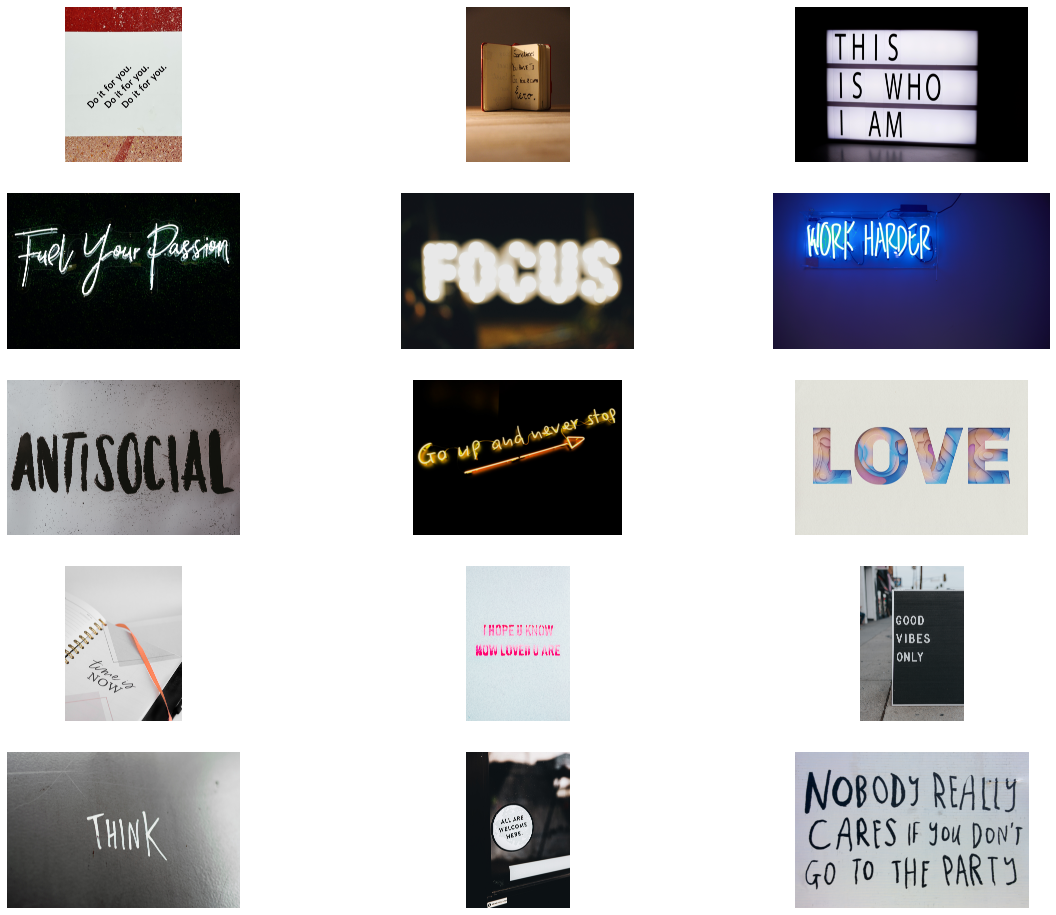

In [3]:
plt.figure(figsize=(20,20))

for idx, im in enumerate(images):
    plt.subplot(6, 3, idx+1)
    im = img.imread(im)
    plt.imshow(im)
    plt.axis('off')

## Google OCR

In [19]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], color, 5)
    return image

In [20]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [21]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/algebraic-cycle-352802-be60b5725757.json'
!ls -l $GOOGLE_APPLICATION_CREDENTIALS
ocr_img = []
ocr_dict = {}

for path in images:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

-rw-r--r-- 1 root root 2341 Jun  9 07:10 /aiffel/aiffel/ocr_python/algebraic-cycle-352802-be60b5725757.json


In [ ]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

## Keras OCR

In [17]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
images = [ keras_ocr.tools.read(url) for url in images]
prediction_groups = [pipeline.recognize([url]) for url in images]

In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [14]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + "/22.4.29. 코랩프로 영수증.jpg"   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png


In [15]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

ㅋㅋ

시

10 :'3()


신한

(8796)해외승인

더

|외승인

이주

도

그

[05)04/29，

1(0:3()

(3()()(>| Ｌ

고 006

나

42,

10)

5:

|

Done


## 테스트 결과

## 결론

## 회고

1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?  
목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.  
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?  
평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.  
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?  
최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.